In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split, ChainDataset
import torch.optim as optim
import matplotlib.pyplot as plt 

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_classes = 2
        img_shape = (1,20,20,20)

        self.model = nn.Sequential(
            nn.Linear((1*20*20*20), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [4]:
realImages = np.load("originalSubsets.npy")
realImages.shape

(1967, 20, 20, 20)

In [5]:
fakeImages = np.load("rescaledSubsets.npy")
fakeImages.shape

(1967, 20, 20, 20)

In [6]:
import random
random.shuffle(realImages)
random.shuffle(fakeImages)
data = []
for realImage in realImages[:1372]:
    data.append((realImage,0.))

for fakeImage in fakeImages[:1372]:
    data.append((fakeImage, 1.))

In [7]:
data = DataLoader(data, shuffle=True)

In [8]:
model = Discriminator().to(device)
print(model)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=8000, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [9]:



adversarial_loss = torch.nn.MSELoss().to(device)

optimizer_D = torch.optim.SGD(model.parameters(), lr=0.001)



In [10]:
iterations = 100
x = []
y = []
for epoch in range(1, iterations+1):
    loss_train = 0.0
    correct = 0
    total = 0    
    for (img, label) in data:
        
        img = img.view(-1).float().to(device)
        label = label.float().to(device)
        model.eval()
        output = model(img)
        
        if output >= .5 and label == 1.:
            correct +=1
        elif output < .5 and label == 0:
            correct+=1
        
        total +=1
        
        optimizer_D.zero_grad()
        errD_real = adversarial_loss(output, label)
        errD_real.backward()
        loss_train+=errD_real.item()
        optimizer_D.step()
        
    x.append(epoch)
    y.append(loss_train)
    
    if epoch == 1 or not epoch % 10:
        print("Epoch: " + str(epoch) + " Training Loss: " + str(loss_train)  
              + " Accuracy: " + str(float(correct/total)))

Epoch: 1 Training Loss: 687.0792573988438 Accuracy: 0.4923469387755102
Epoch: 10 Training Loss: 665.0579213500023 Accuracy: 0.5692419825072886
Epoch: 20 Training Loss: 618.4765559930529 Accuracy: 0.6071428571428571
Epoch: 30 Training Loss: 589.9055464809308 Accuracy: 0.6297376093294461
Epoch: 40 Training Loss: 565.3987080487191 Accuracy: 0.6341107871720116
Epoch: 50 Training Loss: 552.1629909680438 Accuracy: 0.6505102040816326
Epoch: 60 Training Loss: 540.630946274371 Accuracy: 0.6435860058309038
Epoch: 70 Training Loss: 523.534840907956 Accuracy: 0.6592565597667639
Epoch: 80 Training Loss: 515.9429292314644 Accuracy: 0.6661807580174927
Epoch: 90 Training Loss: 501.05008676866953 Accuracy: 0.6818513119533528
Epoch: 100 Training Loss: 487.84453242716427 Accuracy: 0.6916909620991254


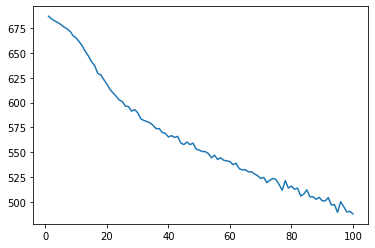

In [13]:
plt.plot(x,y)

In [14]:
testData = []
for realImage in realImages[1372:]:
    testData.append((realImage,0.))

for fakeImage in fakeImages[1372:]:
    testData.append((fakeImage, 1.))

In [15]:
testData = DataLoader(testData, shuffle=True)

In [16]:
testCorrect = 0
testTotal = 0
with torch.no_grad():
    for (img, label) in testData:
        img = img.view(-1).float().to(device)
        label = label.float().to(device)
        model.eval()
        output = model(img)
        
        if output >= .5 and label == 1.:
            testCorrect +=1
        elif output < .5 and label == 0:
            testCorrect+=1
        
        testTotal +=1
        
print("Test accuracy = " + str(float(testCorrect/testTotal)))

Test accuracy = 0.5756302521008403
